In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class Gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def update(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def pdf(self, x):
        pdf = 1 / (((2*np.pi)**(len(self.mu)/2))* (np.linalg.det(self.sigma)**(1/2)))
        pdf *= np.exp((-0.5)*((x-self.mu).T.dot(np.linalg.inv(self.sigma))).dot((x-self.mu)))
        return pdf
    
    def draw2d(self, show=False, axes = None, c = 'k'):
        
        def bivariate_normal(X, Y, sigmax=1.0, sigmay = 1.0, 
                             mux=0.0, muy=0.0, sigmaxy=0.0):
            Xmu = X-mux
            Ymu = Y-muy
            rho = sigmaxy/(sigmax*sigmay)
            z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
            denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
            return np.exp(-z/(2*(1-rho**2))) / denom
        
        delta = 0.025
        lower_xlim = self.mu[0] - (3.0 * self.sigma[0,0])
        upper_xlim = self.mu[0] + (3.0 * self.sigma[0,0])
        lower_ylim = self.mu[1] - (3.0 * self.sigma[1,1])
        upper_ylim = self.mu[1] + (3.0 * self.sigma[1,1])

        x = np.arange(lower_xlim, upper_xlim, delta)
        y = np.arange(lower_ylim, upper_ylim, delta)



        X,Y = np.meshgrid(x,y)
        Z = bivariate_normal(X, Y, self.sigma[0,0], self.sigma[1,1], self.mu[0], self.mu[1], self.sigma[0,1])
        minlim = min(lower_xlim, lower_ylim)
        maxlim = max(upper_xlim, upper_ylim)

        if axes is None:
            fig = plt.figure(num=1, figsize=(4,4))
            plt.contour(X,Y,Z,3,colors=c)
        else:
            axes.contour(X,Y,Z,3,colors=c)

        if show:
            plt.show()

    def __repr__(self):
        return 'Gaussian(mu={}, sigma={})'.format(self.mu, self.sigma)
    

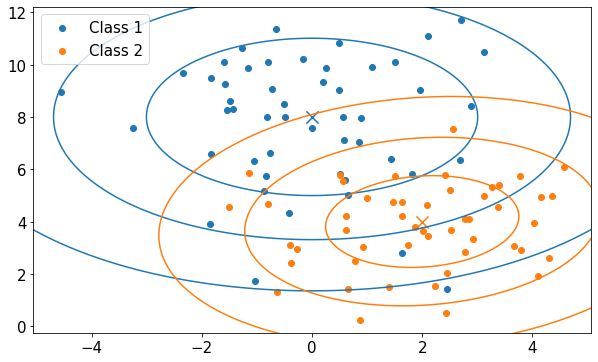

In [5]:
pi_1 = pi_2 = 0.5
mu_1 = np.array([0, 8]).T
mu_2 = np.array([2, 4]).T
sigma_1 = np.array([[4, 0], [0, 4]])
sigma_2 = np.array([[3, 1], [1, 3]])
mu_noise = np.array([0, 0]).T
sigma_noise = (0.25**2) * np.eye(2)
col = ['tab:blue', 'tab:orange']

def p(size):
    s1 = int(size * pi_1)
    s2 = size - s1
    p1 = np.random.multivariate_normal(mu_1, sigma_1, s1) + np.random.multivariate_normal(mu_noise, sigma_noise, s1)
    p2 = np.random.multivariate_normal(mu_2, sigma_2, s2) + np.random.multivariate_normal(mu_noise, sigma_noise, s2) + np.random.multivariate_normal(mu_noise, sigma_noise, s2)
    return p1, p2

sample_1, sample_2 = p(100)
samples = np.concatenate((sample_1, sample_2), axis=0)
np.random.shuffle(samples)

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(sample_1[:,0], sample_1[:,1], c=col[0], label='Class 1')
ax.scatter(sample_2[:,0], sample_2[:,1], c=col[1], label='Class 2')
ax.scatter([mu_1.T[0]], [mu_1.T[1]], c=col[0], marker='x', s = 150)
ax.scatter([mu_2.T[0]], [mu_2.T[1]], c=col[1], marker='x', s = 150)
G1 = Gaussian(mu_1.T, sigma_1)
G2 = Gaussian(mu_2.T, sigma_2)
G1.draw2d(False, axes=ax, c=col[0])
G2.draw2d(False, axes=ax, c=col[1])

xmax, xmin = samples[:,0].max(), samples[:,0].min()
ymax, ymin = samples[:,1].max(), samples[:,1].min()

delta = 0.5

ax.set_xlim(xmin - delta, xmax + delta)
ax.set_ylim(ymin - delta, ymax + delta)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)

In [6]:
class kmeans:
    def __init__(self, K, eps=1e-4):
        self.K = K
        self.center1 = np.random.randn(self.K)
        self.center2 = np.random.randn(self.K)
        self.eps = eps
        
    def eps_equal(self, x, y):
        return np.abs((x-y).sum()) < self.eps
    
    def pred(self, samples):
        dist1 = ((samples-self.center1)**2).sum(axis=1)
        dist2 = ((samples - self.center2)**2).sum(axis=1)
        diff = dist1 - dist2
        label = (diff >0).astype(float)
        loss = (dist1*(1-label) + dist2*label).sum()
        return label, loss
    
    def fit(self, samples, draw=False):
        before1 = before2 = np.zeros(self.K)
        self.center1 += samples.mean()
        self.center2 += samples.mean()

        if draw:
            dx, dy = 3,4
            fig, ax = plt.subplots(dy, dx, sharex = True, sharey = True,
                                    figsize=(30, 20))
            iters = 0

            while not (self.eps_equal(before1, self.center1) and 
                       self.eps_equal(before2, self.center2)):
                before1, before2 = self.center1, self.center2
                label, loss = self.pred(samples)

                mask = label.repeat(self.K, 0).reshape(len(samples), self.K)
                self.center1 = (samples * (1-mask)).sum(0)/ ((1-mask).sum(0) + self.eps)
                self.center2 = (samples * mask).sum(0)/ (mask.sum(0) + self.eps)

                if draw:
                    self.draw(samples, ax[int(iters/dx),iters%dx],
                               'Iteration {}, Loss={:.2f}'.format(iters,loss))
                    iters += 1
                
    def draw(self, samples, ax = None, tit = None):
        def mid_perpendicular(x,p1,p2):
            mid = (p1+p2)/2
            k = (p1[1] - p2[1])/(p1[0]-p2[0] + self.eps*1e-2)
            return -(1/k)*(x-mid[0]) + mid[1]
        label, _ = self.pred(samples)
        l1,l2 = [], []
        for i in range(len(label)):
            if label[i]==1:
                l2.append(samples[i])
            else:
                l1.append(samples[i])
        l1 = np.asarray(l1)
        l2 = np.asarray(l2)
        if ax == None:
            fig,ax = plt.subplots(figsize = (10,6))
        if len(l1)>0:
            ax.scatter(l1[:,0], l1[:,1],label = 'Cluster 1', c = col[0])
        if len(l2)>0:
            ax.scatter(l2[:,0], l2[:,1], label = 'Cluster 2', c = col[1])
        ax.scatter([self.center1[0]], [self.center1[1]], marker = 'x', c= col[0], label = 'Center 1', s = 150)
        ax.scatter([self.center2[0]], [self.center2[1]], marker = 'x', c= col[1], label = 'Center 2', s = 150)
        xmax,xmin = samples[:,0].max(), samples[:,0].min()
        ymax,ymin = samples[:,1].max(), samples[:,1].min()
        delta = 0.5
        x = np.linspace(xmin - delta, xmax + delta)
        y = mid_perpendicular(x, self.center1, self.center2)
        ax.plot(x,y, c = 'tab:red', lw=2, label = 'Decision Boundary')
        ax.set_xlim(xmin - delta, xmax + delta)
        ax.set_ylim(ymin - delta, ymax + delta)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.legend(fontsize=10)
        if tit != None:
            ax.set_title(tit, size=25)
            



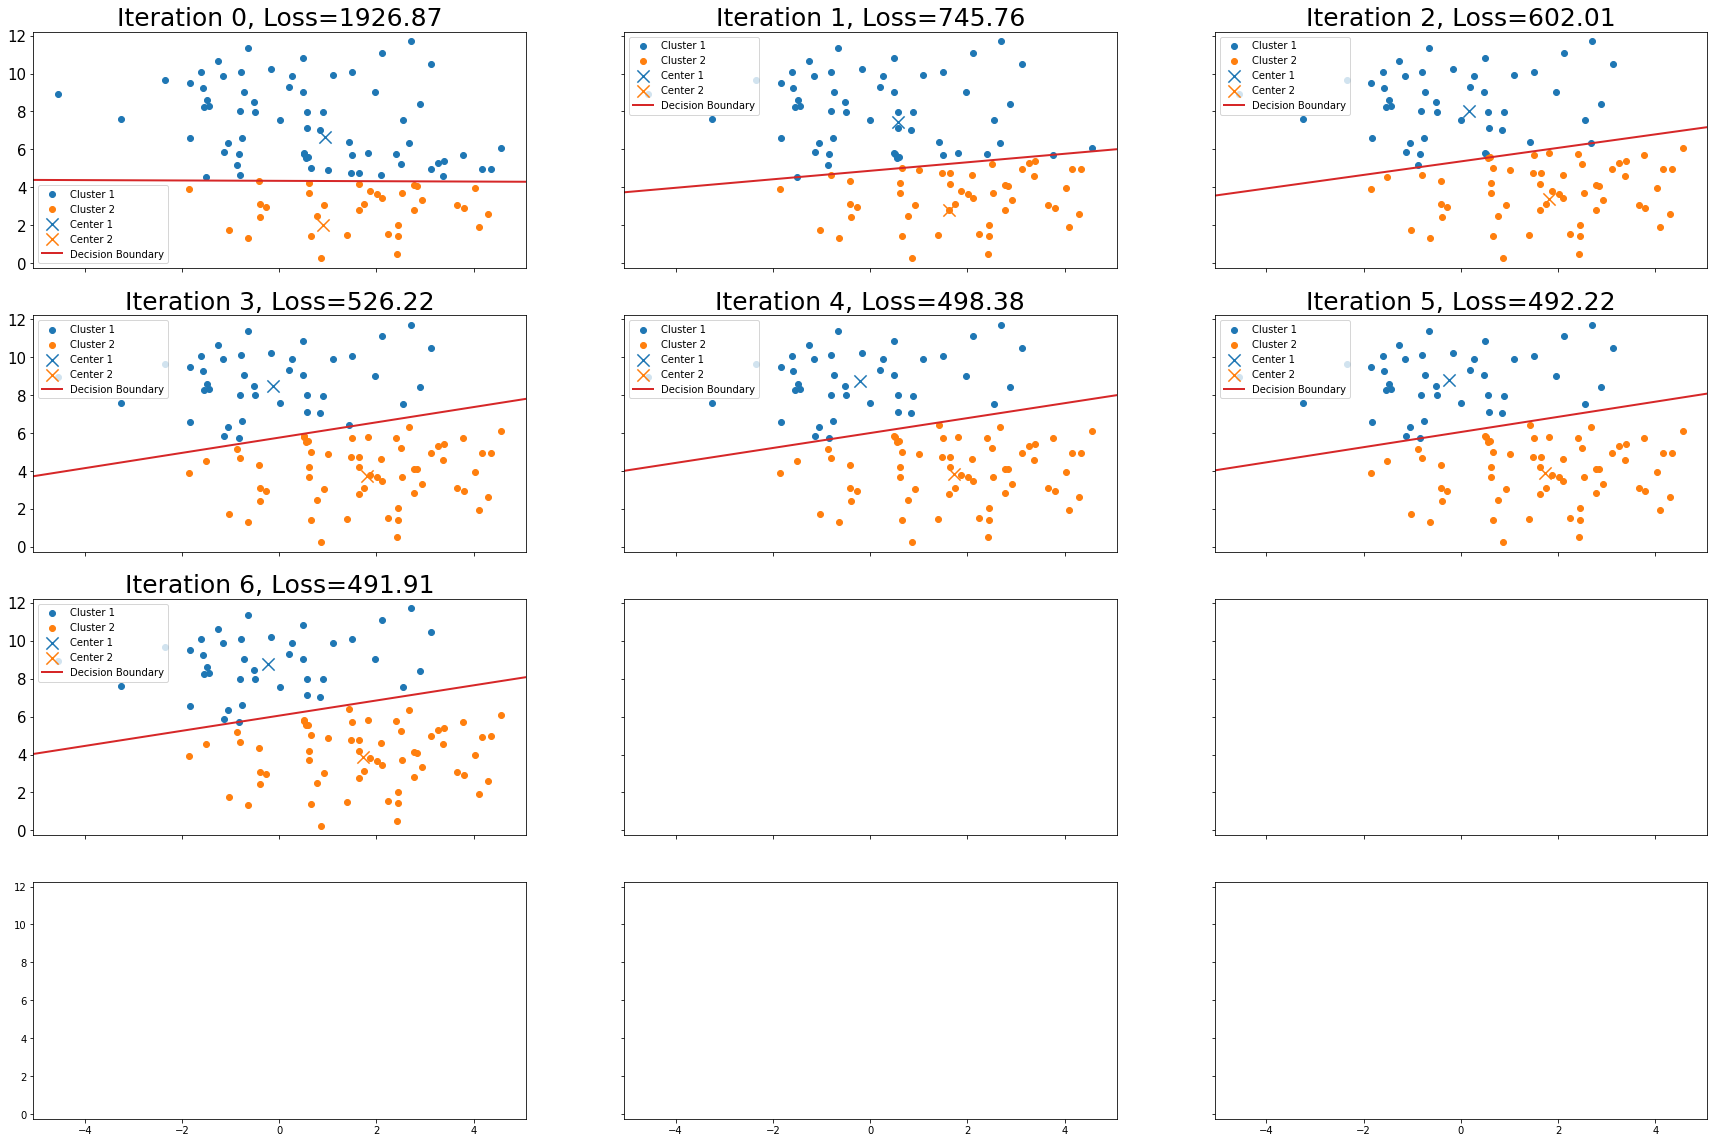

In [7]:
model = kmeans(2)
model.fit(samples, draw = True)

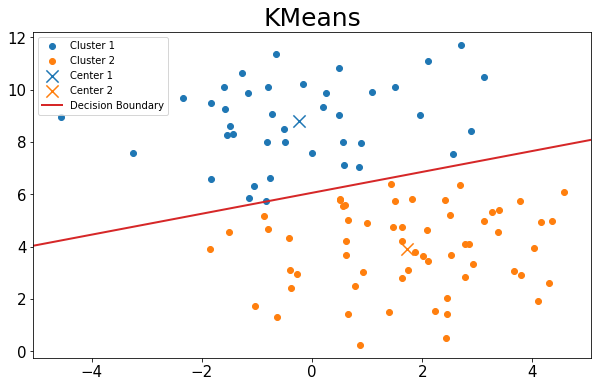

In [8]:
model.draw(samples, None, 'KMeans')

In [9]:
class GMM:
    def __init__(self, K, dim, eps=1e-4):
        self.K = K
        self.dim = dim
        self.pi = np.ones(self.K) / self.K
        self.normals = [Gaussian(np.random.randn(self.dim), np.eye(self.dim)) for _ in range(self.K)]
        self.eps = eps

    def eps_equal(self, x, y):
        return np.abs((x - y).sum()) < self.eps

    def changed(self, before):
        for k in range(self.K):
            if not (self.eps_equal(self.pi[k], before.pi[k]) and
                    self.eps_equal(self.normals[k].mu, before.normals[k].mu) and
                    self.eps_equal(self.normals[k].sigma, before.normals[k].sigma)):
                return True
        return False

    def pred(self, X):
        res = np.zeros((self.K, len(X)))

        for n in range(len(X)):
            for k in range(self.K):
                res[k, n] = self.pi[k] * self.normals[k].pdf(X[n])

            res[:, n] = res[:, n] / res[:, n].sum()
        return res

    def fit(self, X, draw=False):
        before = GMM(self.K, self.dim)
        for k in range(self.K):
            self.normals[k].mu += X.mean()

        if draw:
            dx, dy = 3, 4
            fig, axes = plt.subplots(dx, dy, sharex=True, sharey=True, figsize=(30, 20))
            gap = 15
            iters = 0
            while self.changed(before):
                before.pi = self.pi.copy()
                for k in range(self.K):
                    before.normals[k].mu = self.normals[k].mu.copy()
                    before.normals[k].sigma = self.normals[k].sigma.copy()

                gamma = self.pred(X)

                N = gamma.sum(1)
                for k in range(self.K):
                    mu = np.dot(gamma[k, :], X) / N[k]
                    sigma = np.zeros((self.dim, self.dim))

                    for n in range(len(X)):
                        sigma += gamma[k, n] * np.outer(X[n, :] - mu, X[n, :] - mu)
                    sigma = sigma / N[k]
                    self.normals[k].update(mu, sigma)
                    self.pi[k] = N[k] / N.sum()

                if draw:
                    if iters % gap == 0:
                        self.draw(X, axes[int((iters / gap) // dy), int(iters / gap) % dy],
                                  'Iteration {}'.format(iters))
                    iters += 1

    def draw(self, samples, ax=None, tit=None):
        res = self.pred(samples).T
        l1 = []
        l2 = []
        for i in range(len(res)):
            if res[i][1] > res[i][0]:
                l2.append(samples[i])
            else:
                l1.append(samples[i])
        l1 = np.asarray(l1)
        l2 = np.asarray(l2)
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        if len(l1) > 0:
            ax.scatter(l1[:, 0], l1[:, 1], label='Cluster 1', c=col[0])
        if len(l2) > 0:
            ax.scatter(l2[:, 0], l2[:, 1], label='Cluster 2', c=col[1])
        ax.scatter([self.normals[0].mu[0]], [self.normals[0].mu[1]], marker='x', c=col[0], label='$\mu_1$', s=150)
        ax.scatter([self.normals[1].mu[0]], [self.normals[1].mu[1]], marker='x', c=col[1], label='$\mu_2$', s=150)
        xmax, xmin = samples[:, 0].max(), samples[:, 0].min()
        ymax, ymin = samples[:, 1].max(), samples[:, 1].min()
        delta = 0.5

        for k in range(self.K):
            self.normals[k].draw2d(False, ax, col[k])

        ax.set_xlim(xmin - delta, xmax + delta)
        ax.set_ylim(ymin - delta, ymax + delta)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.legend(fontsize=10)
        if tit is not None:
            ax.set_title(tit, size=25)


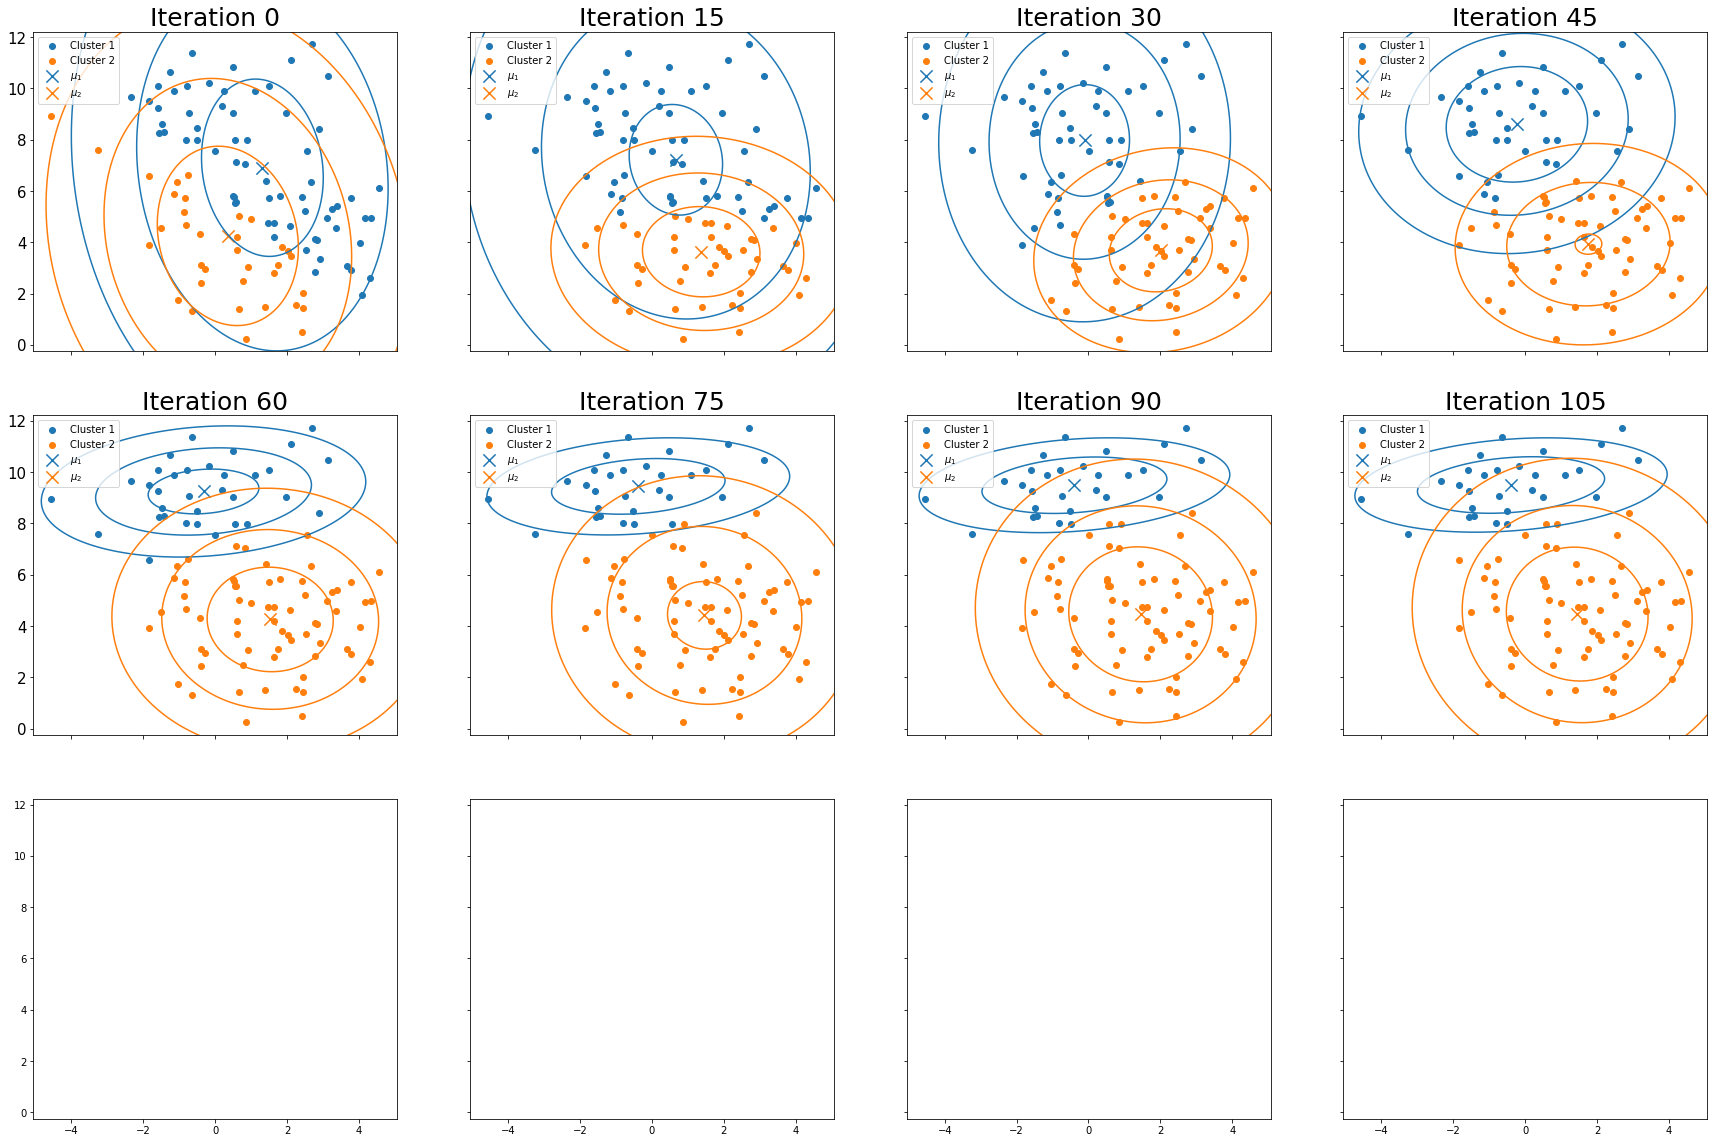

In [10]:
model = GMM(2,2)
model.fit(samples, draw=True)

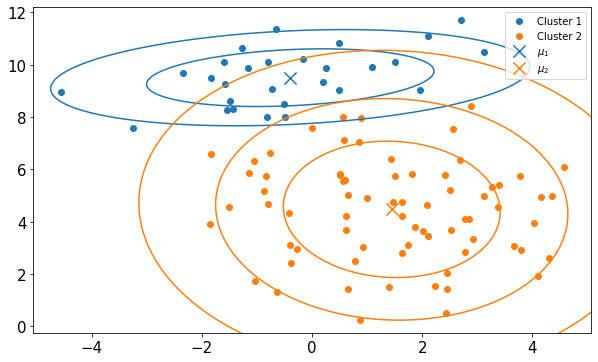

In [11]:
model.draw(samples)

In [13]:
if ((mu_1.T - model.normals[0].mu)**2).sum() > ((mu_1.T - model.normals[1].mu)**2).sum():
    t1 = 1; t2= 0
else:
    t1 = 0; t2 = 1
print('True Pi:{}\nPred Pi: {}\n'.format([pi_1, pi_2], [model.pi[t1], model.pi[t2]]))
print('True Distribution 1:\nmu:\n{}\ncov: \n{}'.format(mu_1.T, sigma_1))
print('Pred Distribution 1: \nmu:\n{}\ncov:\n{}\n'.format(model.normals[t1].mu,model.normals[0].sigma))
print('True Distribution 2:\nmu:\n{}\ncov:\n{}'.format(mu_2.T, sigma_2))
print('Pred Distribution 2: \nmu:\n{}\ncov:\n{}\n'.format(model.normals[t2].mu,model.normals[1].sigma))


True Pi:[0.5, 0.5]
Pred Pi: [0.2768894227175654, 0.7231105772824346]

True Distribution 1:
mu:
[0 8]
cov: 
[[4 0]
 [0 4]]
Pred Distribution 1: 
mu:
[-0.39444598  9.49890097]
cov:
[[2.95504693 0.84111409]
 [0.84111409 1.24896082]]

True Distribution 2:
mu:
[2 4]
cov:
[[3 1]
 [1 3]]
Pred Distribution 2: 
mu:
[1.44712407 4.46619037]
cov:
[[ 2.79764376 -0.42515808]
 [-0.42515808  3.70520324]]

